In [1]:
import sympy as sym
from sympy.vector import CoordSys3D
from sympy import Matrix, powdenest
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.solvers.ode.systems import dsolve_system
init_vprinting(use_latex=True)

In [2]:
# u = sym.Symbol('u')
# v = sym.Symbol('v')
u, v = dynamicsymbols('u v')
ref = CoordSys3D('ref')

# sigma = (sym.cos(u)*sym.cos(v), sym.cos(u)*sym.sin(v), sym.sin(u))
# sigma = sym.cos(u)*sym.cos(v)*ref.i + sym.cos(u)*sym.sin(v)*ref.j + sym.sin(u)*ref.k
# sigma = u*ref.i + v*ref.j + u*v*ref.k
sigma = (u**3 + 1)*sym.cos(v)*ref.i + (u**3 + 1)*sym.sin(v)*ref.j + u*ref.k
# print(sym.diff(sigma, u))
# sym.diff(sigma, u).to_matrix(ref)
sigma

In [3]:
def tangent_plane_basis(sigma):
    return sym.diff(sigma, u).simplify(), sym.diff(sigma, v).simplify()

def first_fundamental_form(sigma):
    sigma_u, sigma_v = tangent_plane_basis(sigma)
    E = sigma_u.dot(sigma_u).simplify()
    F = sigma_u.dot(sigma_v).simplify()
    G = sigma_v.dot(sigma_v).simplify()
    I = Matrix([[E, F], [F, G]])
    return I

def normal_vector(sigma):
    sigma_u, sigma_v = tangent_plane_basis(sigma)
    N = sigma_u.cross(sigma_v).simplify().normalize().simplify()
    return N

def second_fundamental_form(sigma):
    sigma_u, sigma_v = tangent_plane_basis(sigma)
    sigma_uu = sym.diff(sigma_u, u).simplify()
    sigma_uv = sym.diff(sigma_u, v).simplify()
    assert sym.diff(sigma_v, u).simplify() == sigma_uv
    sigma_vv = sym.diff(sigma_v, v).simplify()
    N = normal_vector(sigma)
    e = sigma_uu.dot(N).simplify()
    f = sigma_uv.dot(N).simplify()
    g = sigma_vv.dot(N).simplify()
    II = Matrix([[e, f], [f, g]])
    return II

def christoffel_symbols(sigma):
    I = first_fundamental_form(sigma)
    E_u, E_v = sym.diff(I[0,0], u).simplify(), sym.diff(I[0,0], v).simplify()
    F_u, F_v = sym.diff(I[0,1], u).simplify(), sym.diff(I[0,1], v).simplify()
    G_u, G_v = sym.diff(I[1,1], u).simplify(), sym.diff(I[1,1], v).simplify()
    system_intercepts = Matrix(
        [
            [E_u/2, E_v/2, F_v - G_u/2],
            [F_u - E_v/2, G_u/2, G_v/2]
        ]
    )
    result = ((I**(-1))*system_intercepts)
    return result

def gauss_equations(sigma):
    I  = first_fundamental_form(sigma)
    # II = second_fundamental_form(sigma)
    # K  = (II.det()/I.det()).simplify()
    E, F, G = I[0,0], I[0,1], I[1,1]
    # E, F, G, K = sym.symbols('E,F,G,K')
    K = sym.Symbol('K')
    ch = christoffel_symbols(sigma)
    

    eq1 = sym.Eq(E*K, sym.diff(ch[0,0], v) - sym.diff(ch[1,1], u) + ch[0,0]*ch[1,1] - ch[0,1]*ch[1,0] + ch[1,0]*ch[1,2] - ch[1,1]*ch[1,1])
    eq2 = sym.Eq(F*K, sym.diff(ch[0,1], u) - sym.diff(ch[0,0], v) + ch[1,1]*ch[0,1] - ch[1,0]*ch[0,2])
    eq3 = sym.Eq(G*K, sym.diff(ch[0,2], u) - sym.diff(ch[0,1], v) + ch[0,0]*ch[0,2] + ch[0,1]*ch[1,2] - ch[0,1]*ch[0,1] - ch[1,1]*ch[0,2])
    return eq1, eq2, eq3

def gauss_curvature(sigma, mode='extrinsic'):
    if mode == 'extrinsic':
        I  = first_fundamental_form(sigma)
        II = second_fundamental_form(sigma)
        K  = (II.det()/I.det()).simplify()
        K_sym = sym.Symbol('K')
        return sym.Eq(K_sym, K)
    elif mode == 'intrinsic':
        eqns = gauss_equations(sigma)
        K_sym = sym.Symbol('K')
        for eq in eqns:
            if len(eq.find(0)) == 0:
                sol = sym.solve(eq, K_sym)
                return sym.Eq(K_sym, sol[0])


def geodesics_equations(sigma):
    ch = christoffel_symbols(sigma)
    return sym.Eq(sym.diff(sym.diff(u)) + \
        (Matrix([sym.diff(u), sym.diff(v)]).T * Matrix([[ch[0,0], ch[0,1]], [ch[0,1], ch[0,2]]]) * Matrix([sym.diff(u), sym.diff(v)]))[0].simplify(), 0), \
           sym.Eq(sym.diff(sym.diff(v)) + \
        (Matrix([sym.diff(u), sym.diff(v)]).T * Matrix([[ch[1,0], ch[1,1]], [ch[1,1], ch[1,2]]]) * Matrix([sym.diff(u), sym.diff(v)]))[0].simplify(), 0)

def find_geodesics(sigma):
    eqns = geodesics_equations(sigma)
    geo = dsolve_system(eqns)
    # geo1 = sym.dsolve(eqns[1])
    return geo

def covariant_derivative(sigma, field, dir):
    # primer calculem la derivada "total"
    sigma_u, sigma_v = tangent_plane_basis(sigma)
    total_derivative_along_dir = ...
    # llavors li restem la component normal
    N = normal_vector(sigma)
    covariant_derivative = total_derivative_along_dir - total_derivative_along_dir.dot(N).simplify()*N
    # et voilà! tenim la derivada covariant
    covariant_derivative = covariant_derivative.simplify()
    return covariant_derivative

In [4]:
first_fundamental_form(sigma)

⎡   4               ⎤
⎢9⋅u  + 1      0    ⎥
⎢                   ⎥
⎢                  2⎥
⎢          ⎛ 3    ⎞ ⎥
⎣   0      ⎝u  + 1⎠ ⎦

In [5]:
second_fundamental_form(sigma)

⎡         ⎛ 3    ⎞                                     ⎤
⎢      -6⋅⎝u  + 1⎠⋅u                                   ⎥
⎢──────────────────────────              0             ⎥
⎢    ______________________                            ⎥
⎢   ╱         2                                        ⎥
⎢  ╱  ⎛ 3    ⎞  ⎛   4    ⎞                             ⎥
⎢╲╱   ⎝u  + 1⎠ ⋅⎝9⋅u  + 1⎠                             ⎥
⎢                                                      ⎥
⎢                                            2         ⎥
⎢                                    ⎛ 3    ⎞          ⎥
⎢                                    ⎝u  + 1⎠          ⎥
⎢            0               ──────────────────────────⎥
⎢                                ______________________⎥
⎢                               ╱         2            ⎥
⎢                              ╱  ⎛ 3    ⎞  ⎛   4    ⎞ ⎥
⎣                            ╲╱   ⎝u  + 1⎠ ⋅⎝9⋅u  + 1⎠ ⎦

In [6]:
sym.factor(christoffel_symbols(sigma)).cancel()

⎡     3                 5      2⎤
⎢ 18⋅u             - 3⋅u  - 3⋅u ⎥
⎢────────    0     ─────────────⎥
⎢   4                    4      ⎥
⎢9⋅u  + 1             9⋅u  + 1  ⎥
⎢                               ⎥
⎢              2                ⎥
⎢           3⋅u                 ⎥
⎢   0      ──────        0      ⎥
⎢           3                   ⎥
⎣          u  + 1               ⎦

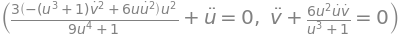

In [7]:
geodesics_equations(sigma)

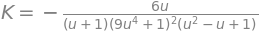

In [8]:
sym.factor(gauss_curvature(sigma, mode='intrinsic'))

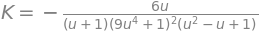

In [9]:
sym.factor(gauss_curvature(sigma, mode='extrinsic'))

In [10]:
sym.cancel(sym.factor(gauss_equations(sigma)))

⎛                                                                             
⎜  ⎛   4    ⎞                -6⋅u                               2 ⎛ 2        ⎞
⎜K⋅⎝9⋅u  + 1⎠ = ───────────────────────────────, True, K⋅(u + 1) ⋅⎝u  - u + 1⎠
⎜                       ⎛   4    ⎞ ⎛ 2        ⎞                               
⎜               (u + 1)⋅⎝9⋅u  + 1⎠⋅⎝u  - u + 1⎠                               
⎝                                                                             

2              ⎛ 2        ⎞   ⎞
    -6⋅(u + 1)⋅⎝u  - u + 1⎠⋅u ⎟
  = ──────────────────────────⎟
                     2        ⎟
           ⎛   4    ⎞         ⎟
           ⎝9⋅u  + 1⎠         ⎠

In [11]:
# find_geodesics(sigma) # Does not work!